# Project 894

In [87]:
from requirements import *
import NHLAPI

## Set Variables

In [111]:
player_name = 'Alex Ovechkin'
player_id = 8471214

def get_player_info(p_id):
    landing_url = f'https://api-web.nhle.com/v1/player/{p_id}/landing'
    raw_json = requests.get(landing_url).json()
    season_totals = raw_json['seasonTotals']
    df = pd.DataFrame()
    for i in season_totals:
        if i['gameTypeId'] == 2:
            df = pd.concat([df, pd.DataFrame(i)])

    df = df.loc[df.index == 'default']
    df = df[df['leagueAbbrev'] == 'NHL']
    df = df.reset_index(drop=True)

    # Add S/G
    df['shots_per_game'] = df['shots'] / df['gamesPlayed']
    return df

career_totals = get_player_info(p_id = player_id)

def get_player_game_log(p_id, season):

    landing_url = f"https://api-web.nhle.com/v1/player/{p_id}/game-log/{season}/2"
    raw_json = requests.get(landing_url).json()['gameLog']
    df = pd.json_normalize(raw_json)
    df = df.sort_values(['gameId'], ascending=True)
    
    # Custom Columns
    df['isHome'] = (df['homeRoadFlag'] == 'H').astype(int)
    df['gameNumber'] = range(len(df))
    df['toi'] = df['toi'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
    df['season'] = season

    # Drop
    if 'opponentCommonName.fr' in df.columns:
        df.drop(columns=['opponentCommonName.fr'], inplace=True)

    return df

all_logs = pd.DataFrame()
for i in career_totals['season']:
    season_df = get_player_game_log(p_id=player_id, season = i)
    all_logs = pd.concat([all_logs, season_df])

all_logs = all_logs.reset_index(drop=True)

# Window Functions
columns_to_roll = ['toi', 'shots', 'shifts', 'pim']
for column in columns_to_roll:
    all_logs[f'{column}_rolling'] = all_logs[column].rolling(window=82, min_periods=1).mean()
    all_logs[f'{column}_rolling_10'] = all_logs[column].rolling(window=10, min_periods=1).mean()
    
all_logs['shootingPct_rolling'] = all_logs['goals'].rolling(window=82, min_periods=1).sum() / all_logs['shots'].rolling(window=82, min_periods=1).sum()
all_logs['shootingPct_rolling_10'] = all_logs['goals'].rolling(window=10, min_periods=1).sum() / all_logs['shots'].rolling(window=10, min_periods=1).sum()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


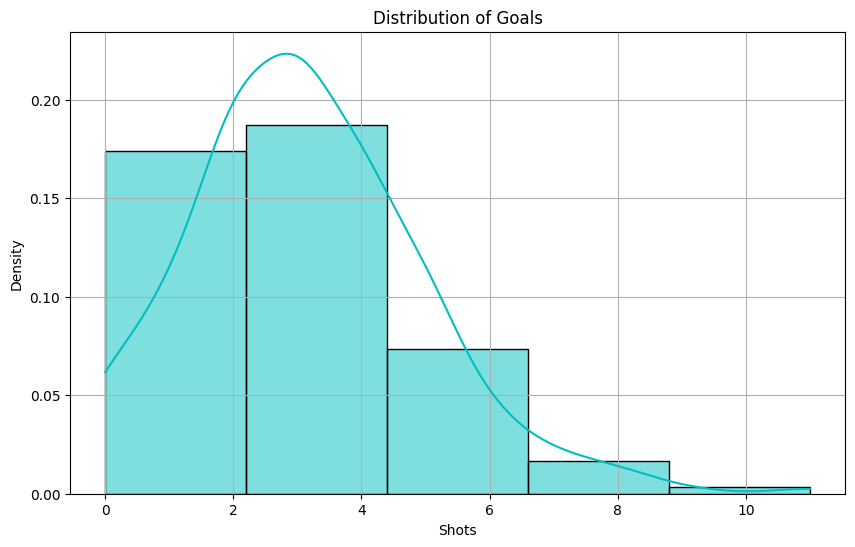

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_logs' is your DataFrame
plt.figure(figsize=(10, 6))

# Using seaborn to create a histogram for 'goals'
sns.histplot(all_logs[all_logs['season'] > 20202021]['shots'], kde=True, bins=5, color='c', stat='density')

# Adding labels and title
plt.xlabel('Shots')
plt.ylabel('Density')
plt.title('Distribution of Goals')

# Show the plot
plt.grid(True)
plt.show()

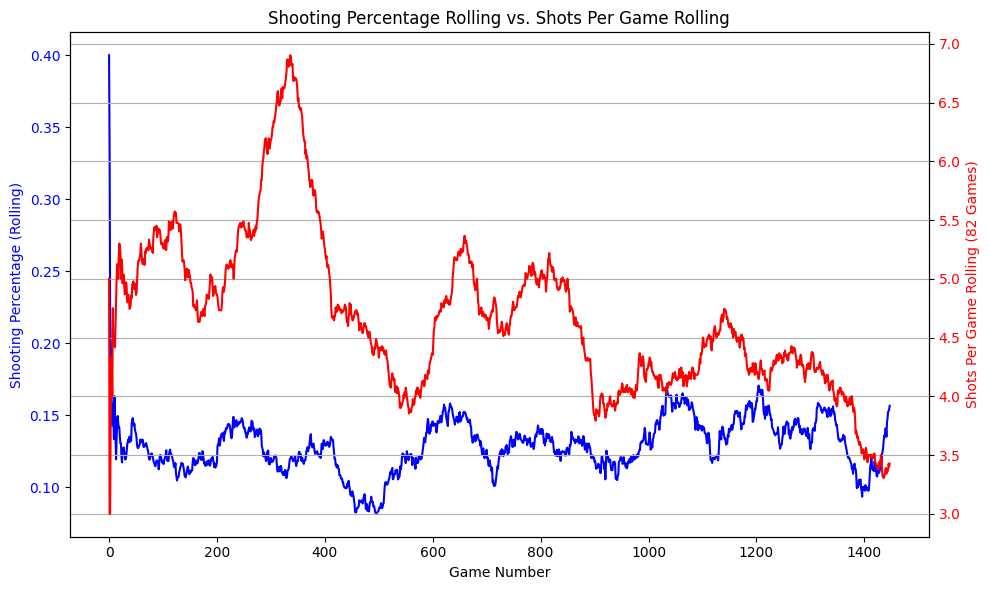

In [112]:
import matplotlib.pyplot as plt

# Assuming 'all_logs' is your DataFrame
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'shootingPct_rolling' on the first y-axis
ax1.plot(all_logs.index, all_logs['shootingPct_rolling'], label='Shooting Percentage Rolling (82 Games)', color='b')
ax1.set_xlabel('Game Number')
ax1.set_ylabel('Shooting Percentage (Rolling)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis to plot 'shots_rolling'
ax2 = ax1.twinx()  
ax2.plot(all_logs.index, all_logs['shots_rolling'], label='Shots Per Game Rolling (82 Games)', color='r')
ax2.set_ylabel('Shots Per Game Rolling (82 Games)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding title and showing the plot
plt.title('Shooting Percentage Rolling vs. Shots Per Game Rolling')
fig.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.grid(True)
plt.show()

In [113]:
# Get Team Schedule
def get_team_schedule(tm):
    url = f"https://api-web.nhle.com/v1/club-schedule-season/{tm}/now"
    raw_json = requests.get(url).json()
    df = pd.json_normalize(raw_json['games'])
    df = df[df['gameState'] == 'FUT']
    df['isHome'] = (df['homeTeam.abbrev'] == tm).astype(int)
    df = df[['id', 'season', 'gameDate', 'homeTeam.abbrev', 'awayTeam.abbrev', 'isHome']]
    df = df.reset_index(drop=True)
    df = df.reset_index().rename(columns={'index': 'gameNumber'})
    df['gameNumber'] = df['gameNumber'] + 1
    
    return(df)

tm_sched = get_team_schedule('WSH')
tm_sched['gameNumber'] = tm_sched['gameNumber'] + all_logs[all_logs['season'] == all_logs['season'].max()]['gameNumber'].iloc[-1].item()

In [114]:
all_logs[['gameNumber', 'isHome', 'shots', 'shifts', 'pim', 'toi',
                  'shots_rolling', 'shifts_rolling', 'pim_rolling', 'toi_rolling',
                  'shots_rolling_10', 'shifts_rolling_10', 'pim_rolling_10', 'toi_rolling_10',
                  'shootingPct_rolling', 'shootingPct_rolling_10']]

,gameNumber,isHome,shots,shifts,pim,toi,shots_rolling,shifts_rolling,pim_rolling,toi_rolling,shots_rolling_10,shifts_rolling_10,pim_rolling_10,toi_rolling_10,shootingPct_rolling,shootingPct_rolling_10
0,0,1,5,21,2,17.600000,5.000000,21.000000,2.000000,17.600000,5.00,21.000000,2.0,17.600000,0.400000,0.400000
1,1,1,1,22,0,17.733333,3.000000,21.500000,1.000000,17.666667,3.00,21.500000,1.0,17.666667,0.333333,0.333333
2,2,0,3,21,4,16.350000,3.000000,21.333333,2.000000,17.227778,3.00,21.333333,2.0,17.227778,0.222222,0.222222
3,3,1,6,18,2,15.050000,3.750000,20.500000,2.000000,16.683333,3.75,20.500000,2.0,16.683333,0.200000,0.200000
4,4,0,6,17,0,13.883333,4.200000,19.800000,1.600000,16.123333,4.20,19.800000,1.6,16.123333,0.190476,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,17,0,3,16,2,14.100000,3.378049,20.890244,0.292683,18.711789,3.70,20.000000,0.4,17.001667,0.148014,0.297297
1444,18,0,3,21,0,14.966667,3.365854,20.890244,0.292683,18.646545,3.90,20.000000,0.4,16.748333,0.152174,0.282051
1445,19,0,8,22,0,20.366667,3.426829,20.914634,0.268293,18.603455,4.30,20.300000,0.4,17.426667,0.153025,0.255814
1446,20,1,3,21,0,16.233333,3.402439,20.939024,0.268293,18.532724,4.10,20.300000,0.4,16.945000,0.154122,0.243902


In [115]:
all_logs['pim_rolling_10'].iloc[-1]

0.4

In [117]:
stat_weight = {
    "labs": ['Career_Pace', "Last_82_Pace", "Last_10_Pace", "Career.15_Last82.70_Last10.15"],
    "Career": [1, 0, 0, .15],
    "Last_82": [0, 1, 0, 0.7],
    "Last_10": [0, 0, 1, 0.15]
}

def simple_projection(weight_dict = stat_weight):
    # Copy Schedule
    fut_df = tm_sched[['gameDate', 'homeTeam.abbrev', 'awayTeam.abbrev', 'gameNumber', 'isHome']].copy()
    # Iterate through each weight configuration
    for i, label in enumerate(weight_dict["labs"]):
        career_weight = weight_dict["Career"][i]
        rolling_82_weight = weight_dict["Last_82"][i]
        rolling_10_weight = weight_dict["Last_10"][i]

        shots_avg = (
            (all_logs['shots'].mean() * career_weight) +
            (all_logs['shots_rolling'].iloc[-1] * rolling_82_weight) +
            (all_logs['shots_rolling_10'].iloc[-1] * rolling_10_weight)
        )

        shootingPct_avg = (
            ((all_logs['goals'].sum() / all_logs['shots'].sum()) * career_weight) +
            (all_logs['shootingPct_rolling'].iloc[-1] * rolling_82_weight) +
            (all_logs['shootingPct_rolling_10'].iloc[-1] * rolling_10_weight)
        )

        fut_df[f'shots_{label}'] = shots_avg
        fut_df[f'shootingPct_{label}'] = shootingPct_avg
        fut_df[f'goals_{label}'] = fut_df[f'shots_{label}'] * fut_df[f'shootingPct_{label}']
        fut_df[f'x{label}'] = fut_df[f'goals_{label}'].cumsum() + 871

    # Filter for home games and select relevant columns
    final = fut_df[fut_df['isHome'] == 1][
        ['gameDate', 'homeTeam.abbrev', 'awayTeam.abbrev'] +
        [f'x{label}' for label in weight_dict["labs"]]
    ]

    return final

simple_projection()


,gameDate,homeTeam.abbrev,awayTeam.abbrev,xCareer_Pace,xLast_82_Pace,xLast_10_Pace,xCareer.15_Last82.70_Last10.15
0,2025-01-04,WSH,NYR,871.601519,871.536585,872.0,871.614418
2,2025-01-08,WSH,VAN,872.804558,872.609756,874.0,872.843253
3,2025-01-10,WSH,MTL,873.406077,873.146341,875.0,873.457671
5,2025-01-14,WSH,ANA,874.609116,874.219512,877.0,874.686507
7,2025-01-18,WSH,PIT,875.812155,875.292683,879.0,875.915342
13,2025-02-01,WSH,WPG,879.421271,878.512195,885.0,879.601849
14,2025-02-04,WSH,FLA,880.022790,879.048780,886.0,880.216267
16,2025-02-09,WSH,UTA,881.225829,880.121951,888.0,881.445102
18,2025-02-23,WSH,EDM,882.428867,881.195122,890.0,882.673938
19,2025-02-25,WSH,CGY,883.030387,881.731707,891.0,883.288355


In [ ]:
from sklearn.linear_model import LinearRegression

def predict_milestone_probability(df):

    # Historical Data Set Up
    hist_df = df[['gameNumber', 'isHome', 'shots', 'shifts', 'pim', 'toi',
          'shots_rolling', 'shifts_rolling', 'pim_rolling', 'toi_rolling',
          'shots_rolling_10', 'shifts_rolling_10', 'pim_rolling_10', 'toi_rolling_10',
          'shootingPct_rolling', 'shootingPct_rolling_10',
          'goals']]
    
    # Future Data Set Up
    fut_df = tm_sched[['gameNumber', 'isHome']]
    fut_df['shots'] = (df['shots'].mean() * 0.3) + (df['shots_rolling'].mean() * 0.5) + (df['shots_rolling_10'].mean() * 0.2)
    fut_df['shifts'] = (df['shifts'].mean() * 0.3) + (df['shifts_rolling'].mean() * 0.5) + (df['shifts_rolling_10'].mean() * 0.2)
    fut_df['pim'] = (df['pim'].mean() * 0.3) + (df['pim_rolling'].mean() * 0.5) + (df['pim_rolling_10'].mean() * 0.2)
    fut_df['toi'] = (df['toi'].mean() * 0.3) + (df['toi_rolling'].mean() * 0.5) + (df['toi_rolling_10'].mean() * 0.2)
    fut_df['shootingPct'] = (df['shootingPct'].mean() * 0.3) + (df['shootingPct_rolling'].mean() * 0.5) + (df['shootingPct_rolling_10'].mean() * 0.2)

    # Current total goals
    current_goals = df['goals'].sum()
    
    # Prep
    model_cols = ['gameNumber', 'isHome', 'shots', 'shifts', 'pim', 'toi',
                  'shots_rolling', 'shifts_rolling', 'pim_rolling', 'toi_rolling',
                  'shots_rolling_10', 'shifts_rolling_10', 'pim_rolling_10', 'toi_rolling_10',
                  'shootingPct_rolling', 'shootingPct_rolling_10']
    
    X = df[model_cols]
    y = df['goals']
    
    # Linear regression to predict the number of goals
    model = LinearRegression()
    model.fit(X, y)

    # Set the goal milestone
    target_goals = 894

    # Initialize variables to keep track of the total goals and number of games
    total_goals = current_goals
    games_to_reach = 0

    # Simulate the future games
    while total_goals < target_goals:
        # Use the most recent data for prediction
        recent_game = df.iloc[-1][model_cols].values.reshape(1, -1)
        
        # Predict the goals for the next game
        predicted_goals = model.predict(recent_game)[0]
        
        # Add the predicted goals to the total goals
        total_goals += predicted_goals
        games_to_reach += 1
        
        # Update the `recent_game` data for the next prediction
        last_game = df.iloc[-1]
        
        # Increment the `gameNumber` (or any other feature that progresses over time)
        next_game = last_game.copy()
        next_game['gameNumber'] += 1  # Increment the game number for the next game
        
        # Optionally, update rolling stats (assume here you calculate the rolling average)
        next_game['toi_rolling'] = (next_game['toi_rolling'] * games_to_reach + next_game['toi']) / (games_to_reach + 1)
        next_game['shots_rolling'] = (next_game['shots_rolling'] * games_to_reach + next_game['shots']) / (games_to_reach + 1)
        next_game['shifts_rolling'] = (next_game['shifts_rolling'] * games_to_reach + next_game['shifts']) / (games_to_reach + 1)
        next_game['shootingPct_rolling'] = (next_game['shootingPct_rolling'] * games_to_reach + (next_game['goals'] / next_game['shots'])) / (games_to_reach + 1)
        
        # Append the next predicted game data to the dataframe
        df = pd.concat([df, next_game], ignore_index=True)

    print(f"Predicted number of games to reach 894 goals: {games_to_reach}")

# Example usage:
# Make sure df is a valid DataFrame (e.g., `all_logs` or other relevant data)
predict_milestone_probability(df=all_logs)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

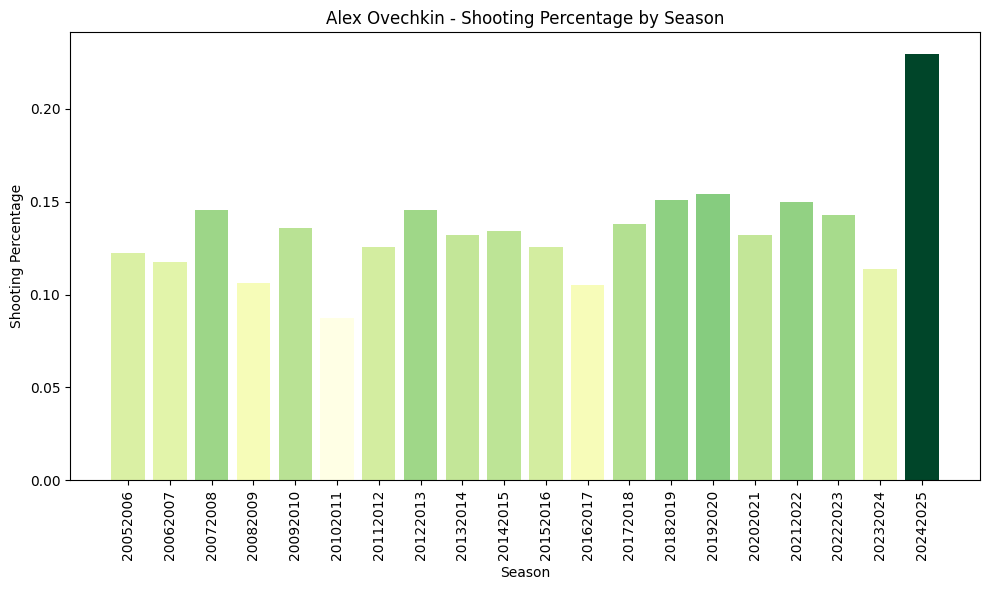

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Assuming `df` is your DataFrame

# Sort the DataFrame by shooting percentage
df_sorted = ovi.sort_values(by='season')

# Normalize the shooting percentages to the range [0, 1]
norm = Normalize(vmin=df_sorted['shootingPctg'].min(), vmax=df_sorted['shootingPctg'].max())

# Create a colormap that goes from white to forest green
cmap = cm.YlGn  # You can change this to any other colormap, e.g., 'YlGn'

# Get the colors for each bar based on shooting percentage
colors = [cmap(norm(value)) for value in df_sorted['shootingPctg']]

# Plotting
plt.figure(figsize=(10,6))
bars = plt.bar(df_sorted['season'].astype(str), df_sorted['shootingPctg'], color=colors)

# Adding labels and title
plt.xlabel('Season')
plt.ylabel('Shooting Percentage')
plt.title(f'{player_name} - Shooting Percentage by Season')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

## Load Schedules

In [2]:
schedule = pd.DataFrame()
for i in range(2021,2026):
    loader = NHLAPI.LoadData(i)
    schedule = pd.concat([schedule, loader.get_schedules()])

# Peek
schedule.head()

  previousStartDate                                           gameWeek  \
0        2025-04-04  [{'date': '2025-04-11', 'dayAbbrev': 'FRI', 'n...   

  preSeasonStartDate regularSeasonStartDate regularSeasonEndDate  \
0         2024-09-21             2024-10-04           2025-04-17   

  playoffEndDate  numberOfGames  
0     2025-06-24             53  
  previousStartDate                                           gameWeek  \
0        2025-04-04  [{'date': '2025-04-11', 'dayAbbrev': 'FRI', 'n...   

  preSeasonStartDate regularSeasonStartDate regularSeasonEndDate  \
0         2024-09-21             2024-10-04           2025-04-17   

  playoffEndDate  numberOfGames  
0     2025-06-24             53  
  previousStartDate                                           gameWeek  \
0        2025-04-04  [{'date': '2025-04-11', 'dayAbbrev': 'FRI', 'n...   

  preSeasonStartDate regularSeasonStartDate regularSeasonEndDate  \
0         2024-09-21             2024-10-04           2025-04-17   

  play

KeyboardInterrupt: 